In [1]:
''' To make an end is to make a beginning


    b a t c h  g r a d i e n t  d e s c e n t 
    
    Play around with number of heads and number of layers; what is the minimum optimal number
    
    Give it unseen dataset within allowable set (i.e. give 0, 1, 0 instead of 2, 2, 2)
    Go from 0-99 :)
    Play around with model, embedding dimension
    
    Another test: keep 0-2, make length longer -->? random
    Make random data set, much larger
    
    Does it learn length?
        Can you feed it varying input lengths with corresponding output lengths and then learn how to do it itself  
        
    For actual physics: make embedding --> nn.Linear
        Would this linear be an actual neural network
'''

import torch
import torch.nn as nn
import time
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class dataLoader():
    def __init__(self):
        self.data = []
        self.target = []
        self.sz = 0
        
    def read_data(self, file):
        with open(file) as data_file:
            data_reader = csv.reader(data_file)
            for row in data_reader:
                sequence = [int(row[0]), int(row[1]), int(row[2])]
                self.data.append(sequence)
        self.data = np.array(self.data)
        
    def get_target(self):
        self.target = np.empty(self.data.shape)
        self.target[:, 0] = self.data[:, 1] + self.data[:, 2]
        self.target[:, 1] = self.data[:, 0] + self.data[:, 2]
        self.target[:, 2] = self.data[:, 0] + self.data[:, 1]
    
    def tensorize(self):
        SOS_token = 5
        EOS_token = 6
        self.data = torch.tensor(self.data).to(torch.long).to(device)
        self.target = torch.tensor(self.target).to(torch.long).to(device)
            
        SOS_ = (torch.ones((self.data.shape[0], 1)) * SOS_token).to(torch.long).to(device)
        EOS_ = (torch.ones((self.data.shape[0], 1)) * EOS_token).to(torch.long).to(device)
        
        self.data = torch.cat((SOS_, self.data, EOS_), 1).to(device)
        self.target = torch.cat((SOS_, self.target, EOS_), 1).to(device)
        
    def sanity_check(self, index, verbose=True):
        print(f'Data has shape of {self.data.shape}')
        print(f'Target has shape of {self.target.shape}')
        print(f'Compare data and target at index {index}: ')
        print(f'    data[{index}] = {self.data[index]}')
        print(f'    target[{index}] = {self.target[index]}')
        
        if verbose:
            for index in range(1, len(self.data)+1):
                print(f'I: {np.array(self.data[index-1].cpu())} --> O: {np.array(self.target[index-1].cpu())}  \*/  ', end='')
                if index != 0 and index % 2 == 0:
                    print('\n')

In [7]:
data_loader = dataLoader()
data_loader.read_data('data.csv')
data_loader.get_target()
data_loader.tensorize()
data_loader.sanity_check(2, verbose=True)

Data has shape of torch.Size([25, 5])
Target has shape of torch.Size([25, 5])
Compare data and target at index 2: 
    data[2] = tensor([5, 0, 0, 2, 6], device='cuda:0')
    target[2] = tensor([5, 2, 2, 0, 6], device='cuda:0')
I: [5 0 0 0 6] --> O: [5 0 0 0 6]  \*/  I: [5 0 0 1 6] --> O: [5 1 1 0 6]  \*/  

I: [5 0 0 2 6] --> O: [5 2 2 0 6]  \*/  I: [5 0 1 1 6] --> O: [5 2 1 1 6]  \*/  

I: [5 0 1 2 6] --> O: [5 3 2 1 6]  \*/  I: [5 0 2 0 6] --> O: [5 2 0 2 6]  \*/  

I: [5 0 2 1 6] --> O: [5 3 1 2 6]  \*/  I: [5 0 2 2 6] --> O: [5 4 2 2 6]  \*/  

I: [5 1 0 0 6] --> O: [5 0 1 1 6]  \*/  I: [5 1 0 1 6] --> O: [5 1 2 1 6]  \*/  

I: [5 1 0 2 6] --> O: [5 2 3 1 6]  \*/  I: [5 1 1 0 6] --> O: [5 1 1 2 6]  \*/  

I: [5 1 1 1 6] --> O: [5 2 2 2 6]  \*/  I: [5 1 1 2 6] --> O: [5 3 3 2 6]  \*/  

I: [5 1 2 1 6] --> O: [5 3 2 3 6]  \*/  I: [5 1 2 2 6] --> O: [5 4 3 3 6]  \*/  

I: [5 2 0 0 6] --> O: [5 0 2 2 6]  \*/  I: [5 2 0 1 6] --> O: [5 1 3 2 6]  \*/  

I: [5 2 0 2 6] --> O: [5 2 4 2 6]  

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_p, max_len):
        super().__init__()

        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, d_model)
        positions_list = torch.arange(0, max_len, dtype=torch.long).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, d_model, 2).long() * (-math.log(10000.0)) / d_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/d_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/d_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

    
class TransformerModel(nn.Module):
    def __init__(self, n_token, d_model, n_head, n_layers):
        super().__init__()
        
        self.d_model = d_model
        self.positional_encoder = PositionalEncoding(
            d_model = d_model, 
            dropout_p = 0.1,
            max_len = 100)
        self.embedding = nn.Embedding(n_token, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=n_head,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers)
        
        # For floating point with one output, then self.out = nn.Linear(d_model, 1)
        self.out = nn.Linear(d_model, n_token) # Learned linear at the end where output of decoder is run through
        
    def get_tgt_mask(self, size):
    
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        return mask
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        
        src = (self.embedding(src) * math.sqrt(self.d_model)).to(device)
        tgt = (self.embedding(tgt) * math.sqrt(self.d_model)).to(device)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        
        transformer_output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask).to(device)
        output = self.out(transformer_output).to(device)
        
        output = output.permute(1, 2, 0).to(device)
        
        return output

In [9]:
# Let's define an instance :)
d_model = 60 # Let's try embedding brotha
n_token = 7 # Only do 0, 1, 2?
n_head = 3 # Remember that d_model=d_embedding must be divisible by number of n_head
n_layers = 4

model = TransformerModel(n_token, d_model, n_head, n_layers).to(device)

print(f'The number of tokens are {n_token}, six categories to calculate probability distributions over (i.e. 0, 1, 2, 3, 4 + sos + eos)')

# Check da dimension
src = torch.randint(size=(2, 3), low=0, high=2).to(device)
tgt = src.to(device)

output = model(src, src).to(device)
print(f'src:\n  Size: {src.size()}\n  Tensor: {src}')
print(f'tgt:\n  Size: {tgt.size()}\n  Tensor: {tgt}')
print(f'output:\n  Size: {output.size()}\n  Tensor: {output}\n')

src = torch.randint(size=(2, 3), low=0, high=2).to(device)
tgt = src.to(device)
tgt_input = tgt[:, :-1].to(device)
tgt_expected = tgt[:, 1:].to(device)
output = model(src, tgt_input).to(device)

print('----------------------------------------------------------------------------')
print(f'src:\n  Size: {src.size()}\n  Tensor: {src}')
print(f'tgt_input:\n  Size: {tgt_input.size()}\n  Tensor: {tgt_input}')
print(f'output:\n  Size: {output.size()}\n  Tensor: {output}')

The number of tokens are 7, six categories to calculate probability distributions over (i.e. 0, 1, 2, 3, 4 + sos + eos)
src:
  Size: torch.Size([2, 3])
  Tensor: tensor([[0, 0, 0],
        [1, 1, 0]], device='cuda:0')
tgt:
  Size: torch.Size([2, 3])
  Tensor: tensor([[0, 0, 0],
        [1, 1, 0]], device='cuda:0')
output:
  Size: torch.Size([2, 7, 3])
  Tensor: tensor([[[-0.7346, -0.9109, -0.8613],
         [-0.1324, -0.1715,  0.0156],
         [-0.0171,  0.4595,  0.4978],
         [-0.0071,  0.1696,  0.0319],
         [ 0.1899,  0.5474,  1.2257],
         [-0.2732,  0.2747, -0.0718],
         [ 0.3814,  0.5105,  0.4273]],

        [[-0.5216, -0.0158, -0.1174],
         [-0.6977, -0.5814, -0.6106],
         [ 0.4445,  0.3799,  0.8668],
         [-0.9561, -0.5316, -0.4545],
         [ 0.0316,  0.2670, -0.3350],
         [-0.9354, -0.4088, -0.8884],
         [-0.9278, -0.5854, -0.5199]]], device='cuda:0',
       grad_fn=<PermuteBackward>)

------------------------------------------------

In [10]:
# America needs more trains
opt = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

def train(model, data, target):
    model.train()
    total_loss = 0
    start_time = time.time()
    data = data.type(torch.long).to(device)
    target = target.type(torch.long).to(device)
          
    target_in = target[:, :-1]
    target_expected = target[:, 1:]

    sequence_length = target_in.size(1)
    
    tgt_mask = model.get_tgt_mask(sequence_length).to(device)
    src_mask = model.get_tgt_mask(data.size(1)).to(device)
    pred = model(data, target_in, src_mask, tgt_mask)
    
    loss = (loss_fn(pred, target_expected)).type(torch.float)
        
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    total_loss += loss.detach().item()
        
    return total_loss
    
def train_loop(model, n_epochs, data, target):
    best_loss = 10000.0
    best_model = copy.deepcopy(model).to(device)
    loss_ = np.array([])
    epochs = np.array([])
    
    for i in range(n_epochs):
        loss = train(model, data, target)
        loss_ = np.append(loss_, loss)
        epochs = np.append(epochs, i)
        
        if loss < best_loss:
            best_loss = loss
            best_model = copy.deepcopy(model).to(device)
                     
        if i % 10 == 0:
            print(f'Epoch: {i}\nTotal Loss: {loss}')
            print(f'----------------------------------')
    
    return best_model, loss_, epochs

In [11]:
n_epochs = 3000
best_model, loss_, epochs = train_loop(model, n_epochs, data_loader.data, data_loader.target)

Epoch: 0
Total Loss: 1.918920636177063
----------------------------------
Epoch: 10
Total Loss: 1.7440413236618042
----------------------------------
Epoch: 20
Total Loss: 1.6725871562957764
----------------------------------
Epoch: 30
Total Loss: 1.564504861831665
----------------------------------
Epoch: 40
Total Loss: 1.468981146812439
----------------------------------
Epoch: 50
Total Loss: 1.3954474925994873
----------------------------------
Epoch: 60
Total Loss: 1.336423635482788
----------------------------------
Epoch: 70
Total Loss: 1.2528495788574219
----------------------------------
Epoch: 80
Total Loss: 1.2248183488845825
----------------------------------
Epoch: 90
Total Loss: 1.1895867586135864
----------------------------------
Epoch: 100
Total Loss: 1.1719690561294556
----------------------------------
Epoch: 110
Total Loss: 1.095517873764038
----------------------------------
Epoch: 120
Total Loss: 1.099975347518921
----------------------------------
Epoch: 130
Total

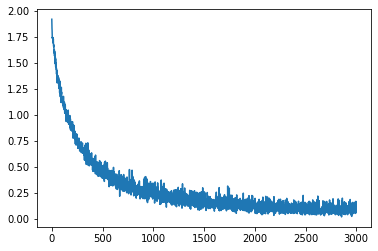

In [12]:
plt.plot(epochs, loss_)
plt.show()

In [13]:
def predict(model, input_seq, max_length=5, SOS_token=5, EOS_token=6, verbose=False):
    model.eval()
    
    target_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    # Asks model to give only one item, the next thing it thinks is most probable 
    # to continue the sentence
    for i in range(max_length):
        sequence_length = target_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)
        src_mask = model.get_tgt_mask(input_seq.size(1)).to(device)
        
        #print(input_seq)
        pred = model(input_seq, target_input, src_mask, tgt_mask)
        
        pred = pred.permute(2, 0, 1)
        
        if verbose:
            print(pred.cpu().squeeze().detach().numpy())
            print(pred.topk(1))
            print(pred.topk(1)[1].view(-1)[-1].item())
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability, twas view(-1)[-1] before
    
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        target_input = torch.cat((target_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break
        elif (len(target_input.view(-1)) >= len(input_seq[0])):
            break

    return target_input.view(-1).tolist()

def test_example(model, example, data_loader, i):
    result = predict(model, example)
    print(f"Input: {example.view(-1).tolist()[1:-1]} --> Prediction: {result[1:-1]}  vs Actual: {data_loader.target[i].view(-1).tolist()[1:-1]}\n")

In [15]:
# The reckoning
print('Moment of Truth; Has it at least memorized the data?')
print('------------------------------------')

for i, sequence in enumerate(data_loader.data):
    sequence = torch.unsqueeze(sequence, dim=0)
    test_example(best_model, sequence, data_loader, i)
print('Did it maybe possible work? Ich würde viele Aufregung haben, als das passieren würde!')

# This time, I removed 0, 1, 0 from the dataset and added 2, 2, 2 to the set
print('Let uns check the Wahrscheinlichkeiten, yo: ')
example = torch.tensor([[5, 2, 2, 2, 6]]).type(torch.long).to(device)
result = predict(model, example, verbose=True)
print(f"Example")
print(f"Input: {example.view(-1).tolist()[1:-1]} --> Continutation: {result[1:-1]}\n")

Moment of Truth; Has it at least memorized the data?
------------------------------------
Input: [0, 0, 0] --> Prediction: [0, 0, 0]  vs Actual: [0, 0, 0]

Input: [0, 0, 1] --> Prediction: [1, 1, 0]  vs Actual: [1, 1, 0]

Input: [0, 0, 2] --> Prediction: [2, 2, 0]  vs Actual: [2, 2, 0]

Input: [0, 1, 1] --> Prediction: [2, 1, 1]  vs Actual: [2, 1, 1]

Input: [0, 1, 2] --> Prediction: [3, 2, 1]  vs Actual: [3, 2, 1]

Input: [0, 2, 0] --> Prediction: [2, 0, 2]  vs Actual: [2, 0, 2]

Input: [0, 2, 1] --> Prediction: [3, 1, 2]  vs Actual: [3, 1, 2]

Input: [0, 2, 2] --> Prediction: [4, 2, 2]  vs Actual: [4, 2, 2]

Input: [1, 0, 0] --> Prediction: [0, 1, 1]  vs Actual: [0, 1, 1]

Input: [1, 0, 1] --> Prediction: [1, 2, 1]  vs Actual: [1, 2, 1]

Input: [1, 0, 2] --> Prediction: [2, 3, 1]  vs Actual: [2, 3, 1]

Input: [1, 1, 0] --> Prediction: [1, 1, 2]  vs Actual: [1, 1, 2]

Input: [1, 1, 1] --> Prediction: [2, 2, 2]  vs Actual: [2, 2, 2]

Input: [1, 1, 2] --> Prediction: [3, 3, 2]  vs Actua

In [243]:
print(best_model.embedding.weight.size())
print(best_model.embedding.weight[0])
print(best_model.embedding(torch.tensor([0]).to(device)))

torch.Size([7, 60])
tensor([-0.0249, -2.8021, -0.4377,  0.9583,  0.3198,  0.9471,  1.8276,  0.2293,
         1.3250, -0.4521,  1.3166,  1.0119,  0.9855, -1.0482, -0.7652,  0.6970,
         0.0161,  0.2890,  1.1278,  0.0309, -0.6450, -0.0514, -0.6065, -0.9043,
         0.2349,  0.1062, -1.1840,  1.3056,  0.6100, -1.0321, -0.3453, -0.9089,
        -0.9279,  0.2735, -1.2436, -2.4410, -0.0768,  0.2881,  0.2943,  2.1848,
         0.0882, -0.1254, -0.7018,  0.0851, -0.5261, -2.7904, -0.1752, -1.1616,
        -0.4065, -1.5997,  0.4245, -1.2996, -1.6391,  0.1359, -0.8933, -2.1602,
        -2.9080, -1.5079, -0.6556,  0.4100], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[-0.0249, -2.8021, -0.4377,  0.9583,  0.3198,  0.9471,  1.8276,  0.2293,
          1.3250, -0.4521,  1.3166,  1.0119,  0.9855, -1.0482, -0.7652,  0.6970,
          0.0161,  0.2890,  1.1278,  0.0309, -0.6450, -0.0514, -0.6065, -0.9043,
          0.2349,  0.1062, -1.1840,  1.3056,  0.6100, -1.0321, -0.3453, -0.9089,
 